In [4]:
import os
import json
from PIL import Image
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Subset, DataLoader, random_split
from torchvision import transforms
import torch.optim as optim
from tqdm import tqdm
import cv2
from scipy.spatial import KDTree

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

**Data Preprocessing**

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, file_names, color_map, color_tree):
        self.data_dir = data_dir
        self.file_names = file_names
        self.color_tree = color_tree
        self.color_map = color_map
        self.images = []
        self.masks = []

        # Load images and masks
        for file_name in self.file_names:
            image_path = os.path.join(data_dir, 'images', file_name)
            mask_path = os.path.join(data_dir, 'masks', file_name.replace('.jpg', '_mask.png'))
            self.images.append(image_path)
            self.masks.append(mask_path)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # Load image and mask
        image = torch.from_numpy(cv2.resize(cv2.imread(self.images[idx]), (224, 224))).float()

#         mask = Image.open(self.masks[idx]).convert("RGB")
        mask = cv2.resize(cv2.imread(self.masks[idx]), (224, 224))
        mask = torch.from_numpy(np.eye(len(self.color_map))[self.color_tree.query(mask*255)[1]]).float()


        # Convert RGB mask to class indices
#         mask = np.array(mask)
#         mask = rgb_to_class_index(mask, self.label_to_mask_map)
#         mask = torch.from_numpy(mask).long()  # Ensure the mask is a long tensor for compatibility with loss functions
        return image, mask



# Define paths and parameters
data_dir = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_2/dataset'
split_file = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_2/dataset/train_test_split.json'
label2cmap_file = '/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_2/dataset/label2cmap.json'
batch_size = 16

# Load train-test split from JSON file
with open(split_file, 'r') as f:
    split_data = json.load(f)

with open(label2cmap_file, 'r') as f:
    label2cmap = json.load(f)


# Convert the original data to a mapping of integer indices to RGB values
# label_to_mask_map = {index: rgb for index, (class_name, rgb) in enumerate(label2cmap.items())}

color_map = [label2cmap[labels] for labels in label2cmap]
color_tree = KDTree(color_map.copy())

#Json data can be accessed in a dictionary fashion after loading
train_file_names = split_data['train']
test_file_names = split_data['test']


# Create datasets and data loaders
train_dataset = CustomDataset(data_dir, train_file_names, color_map, color_tree)
test_dataset = CustomDataset(data_dir, train_file_names, color_map, color_tree)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
image = torch.from_numpy(cv2.resize(cv2.imread("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_2/dataset/images/2022-08-24 (10).png"), (224, 224))).float()

#         mask = Image.open(self.masks[idx]).convert("RGB")
mask = cv2.resize(cv2.imread("/content/drive/MyDrive/Second Sem_IISc/AIP/Assignment_2_Shubhankar Mondal_22456/Question_2/dataset/masks/2022-08-24 (10).png"), (224, 224))
mask = torch.from_numpy(np.eye(len(color_map))[color_tree.query(mask*255)[1]]).float()

print(image.shape, mask.shape)

torch.Size([224, 224, 3]) torch.Size([224, 224, 9])


In [8]:
dataset = train_loader.dataset  # Assuming your DataLoader wraps a Dataset object
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training, adjust as needed

# Split dataset into train and validation sets
train_dataset, val_dataset = random_split(dataset, [train_size, dataset_size - train_size])

# Create DataLoader objects for train and validation sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [9]:
class ResNet18_FCN_NoSkip(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_FCN_NoSkip, self).__init__()
        # Load a pre-trained ResNet-18 model
        self.resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Remove the average pooling and fully connected layer
        self.layer1 = nn.Sequential(*list(self.resnet18.children())[:8])
        # Add a 1x1 conv layer to get the desired num_classes
        # self.conv1x1 = nn.Conv2d(512, num_classes, 1)

        self.layer2 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(256),nn.ReLU())

        self.layer3 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(128),nn.ReLU())

        self.layer4 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(64),nn.ReLU())

        self.layer5 = nn.Sequential(nn.Conv2d(64, num_classes, kernel_size=1,stride=1,padding=0),
                        nn.AdaptiveAvgPool2d((224, 224)))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)

        return x

In [10]:
class ResNet18_FCN_Skip(nn.Module):
    def __init__(self, num_classes):
        super(ResNet18_FCN_Skip, self).__init__()
        # Load a pre-trained ResNet-18 model
        resnet18 = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        # Take the layers from ResNet-18 before the fully connected layer
        self.layer1 = nn.Sequential(*list(resnet18.children())[:5])  # End at layer 4
        self.layer2 = list(resnet18.children())[5]  # Layer 5
        self.layer3 = list(resnet18.children())[6]  # Layer 6
        self.layer4 = list(resnet18.children())[7]  # Layer 7, before avgpool and fc

        # Convolution to reduce the channel size to num_classes
        # self.conv1x1 = nn.Conv2d(512, num_classes, 1)

        self.layer5 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(512,256,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(256),nn.ReLU())

        self.layer6 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(256,128,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(128),nn.ReLU())

        self.layer7 = nn.Sequential(nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
                        nn.Conv2d(128,64,kernel_size=3,stride=1,padding=1),
                        nn.BatchNorm2d(64),nn.ReLU())

        self.layer8 = nn.Sequential(nn.Conv2d(64, num_classes, kernel_size=1,stride=1,padding=0),
                        nn.AdaptiveAvgPool2d((224, 224)))

    def forward(self, x):
        op1 = x = self.layer1(x)
        op2 = x = self.layer2(x)
        op3 = x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x+op3)
        x = self.layer7(x+op2)
        x = self.layer8(x+op1)

        return x

In [11]:
#Parameters
num_classes = 9  # Update this based on your dataset
num_epochs = 25  # Number of epochs for training
# batch_size = 4  # Batch size for training and validation
learning_rate = 0.001  # Learning rate for the optimizer

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
def train_val(model):

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Lists for storing loss and accuracy values
    train_losses = []
#     train_accuracies = []
    val_losses = []
#     val_accuracies = []

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
#         correct = 0
#         total = 0
        for images, masks in tqdm(train_loader):
            images, masks = images.to(device), masks.to(device)
            images=images.permute(0,3,1,2)
            masks=masks.permute(0,3,1,2)
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total += masks.size(0) * masks.size(1) * masks.size(2) # total number of pixels
#             correct += (predicted == masks).sum().item()

#         train_accuracy = 100 * correct / total
#         train_accuracies.append(train_accuracy)

        # Calculate and print average loss for the epoch
        epoch_loss = running_loss / len(train_loader)
        train_losses.append(epoch_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
#             correct = 0
#             total = 0
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                images=images.permute(0,3,1,2)
                masks=masks.permute(0,3,1,2)

                outputs = model(images)

                loss = criterion(outputs, masks)
                running_loss += loss.item()

#                 _, predicted = torch.max(outputs.data, 1)
#                 total += masks.size(0) * masks.size(1) * masks.size(2) # total number of pixelsmasks.size(0)
#                 correct += (predicted == masks).sum().item()

#             val_accuracy = 100 * correct / total
#             val_accuracies.append(val_accuracy)
            epoch_loss = running_loss / len(val_loader)
            val_losses.append(epoch_loss)

        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}')
        print(f'Epoch {epoch+1}, Val Loss: {val_losses[-1]}')

    print('Finished Training')
    return train_losses, val_losses
# , train_accuracies, val_accuracies

In [13]:
def plot_acc_loss(train_losses, val_losses, skp_type=""):
#     plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.title(f'Loss over Epochs ({skp_type})')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(train_accuracies, label='Training Accuracy')
#     plt.plot(val_accuracies, label='Val Accuracy')
#     plt.title(f'Accuracy over Epochs ({skp_type})')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()

    plt.tight_layout()
    plt.show()

In [14]:
def pixelwise_accuracy(outputs, targets):
    """
    Computes the pixel-wise accuracy.

    Parameters:
    - output: the model's predictions.
    - target: the ground truth labels.

    Returns:
    - accuracy: the pixel-wise accuracy.
    """

    acc = []
    for target, output in zip(targets, outputs):
        output=output.cpu().detach().numpy()
        target=target.cpu().detach().numpy()
        _,h,w=target.shape
        size=h*w
        acc += [np.logical_and(target, output).sum()/size]
    return acc

def mean_iou(outputs, targets, num_classes):
    """
    Computes the mean Intersection over Union (IoU).

    Parameters:
    - output: the model's predictions.
    - target: the ground truth labels.
    - num_classes: the number of classes in the segmentation task.

    Returns:
    - mean_iou: the mean IoU for all classes.
    """

    mean_iou = []
    for target, output in zip(targets, outputs):
        output=output.cpu().detach().numpy()
        target=target.cpu().detach().numpy()
        c,_,_=target.shape
        iou=0
        for i in range(c):
            intersection = np.logical_and(target[i,:,:], output[i,:,:]).sum()
            union = np.logical_or(target[i,:,:], output[i,:,:]).sum()
            iou += (intersection / union)*100 if union != 0 else 0
        mean_iou += [iou / c]
    return mean_iou

In [15]:
def test(model):
    model.eval()  # Set model to evaluation mode
    total_accuracy = []
    total_iou = []
    num_samples = 0

    with torch.no_grad():
        for images, masks in test_loader:
            images, masks = images.to(device), masks.to(device)
            images=images.permute(0,3,1,2)
            masks=masks.permute(0,3,1,2)

            outputs = model(images)

            total_accuracy += pixelwise_accuracy(outputs, masks)
            total_iou += mean_iou(outputs, masks, num_classes=num_classes)
            num_samples += 1

    # Calculate average accuracy and mean IoU
    avg_accuracy = np.mean(total_accuracy)
    avg_iou = np.mean(total_iou)

    print(f'Average Pixel-wise Accuracy: {avg_accuracy:.4f}, Average Mean IoU: {avg_iou:.4f}')

In [16]:
def train_test_model(model, skp="Skip"):
    train_losses, val_losses= train_val(model)
    plot_acc_loss(train_losses, val_losses, skp)
    test(model)

In [17]:
model1 = ResNet18_FCN_Skip(num_classes).to(device)
# train_test_model(model1, "Skip")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s]


100%|██████████| 13/13 [02:48<00:00, 12.95s/it]


Epoch 1, Train Loss: 1.0724813961065733
Epoch 1, Val Loss: 0.6568357944488525


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 2, Train Loss: 0.3860539931517381
Epoch 2, Val Loss: 0.35760512202978134


100%|██████████| 13/13 [00:21<00:00,  1.63s/it]


Epoch 3, Train Loss: 0.23922751614680657
Epoch 3, Val Loss: 0.23369202390313148


100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


Epoch 4, Train Loss: 0.23332606599881098
Epoch 4, Val Loss: 0.21762583777308464


100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 5, Train Loss: 0.16926501805965716
Epoch 5, Val Loss: 0.23542750254273415


100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 6, Train Loss: 0.1366928185407932
Epoch 6, Val Loss: 0.17638833075761795


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 7, Train Loss: 0.12296073826459739
Epoch 7, Val Loss: 0.16802928782999516


100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 8, Train Loss: 0.10812118019048984
Epoch 8, Val Loss: 0.16031420789659023


100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 9, Train Loss: 0.11519105445880157
Epoch 9, Val Loss: 0.1598028540611267


100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 10, Train Loss: 0.1248016030742572
Epoch 10, Val Loss: 0.209783636033535


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 11, Train Loss: 0.11216558172152592
Epoch 11, Val Loss: 0.16707562655210495


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 12, Train Loss: 0.09788268517989379
Epoch 12, Val Loss: 0.16283780056983232


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 13, Train Loss: 0.08849104092671321
Epoch 13, Val Loss: 0.15672078542411327


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 14, Train Loss: 0.08047061528150852
Epoch 14, Val Loss: 0.15240179933607578


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 15, Train Loss: 0.07724972785665439
Epoch 15, Val Loss: 0.16073473915457726


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 16, Train Loss: 0.07128459215164185
Epoch 16, Val Loss: 0.1493661031126976


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 17, Train Loss: 0.06592927643885979
Epoch 17, Val Loss: 0.1505101788789034


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 18, Train Loss: 0.06492919532152322
Epoch 18, Val Loss: 0.15333170257508755


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 19, Train Loss: 0.06391724542929576
Epoch 19, Val Loss: 0.14945144020020962


100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


Epoch 20, Train Loss: 0.10000004304143098
Epoch 20, Val Loss: 0.21809902973473072


100%|██████████| 13/13 [00:21<00:00,  1.65s/it]


Epoch 21, Train Loss: 0.12189824764545147
Epoch 21, Val Loss: 0.24568086862564087


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 22, Train Loss: 0.09454761101649357
Epoch 22, Val Loss: 0.275302916765213


100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


Epoch 23, Train Loss: 0.07722528937917489
Epoch 23, Val Loss: 0.13557427935302258


100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


Epoch 24, Train Loss: 0.09568483669024247
Epoch 24, Val Loss: 0.141428436152637


100%|██████████| 13/13 [00:20<00:00,  1.61s/it]


Epoch 25, Train Loss: 0.0935759240618119
Epoch 25, Val Loss: 0.27905402332544327
Finished Training


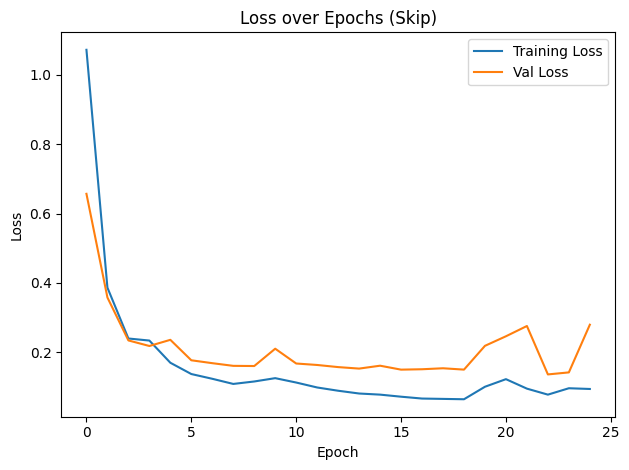

In [18]:
train_losses, val_losses= train_val(model1)
plot_acc_loss(train_losses, val_losses, "Skip")

In [19]:
test(model1)

Average Pixel-wise Accuracy: 1.0000, Average Mean IoU: 11.1111


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 1, Train Loss: 1.2579984664916992
Epoch 1, Val Loss: 1.3585839867591858


100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 2, Train Loss: 0.7156260151129502
Epoch 2, Val Loss: 0.5425497516989708


100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 3, Train Loss: 0.46407342186340916
Epoch 3, Val Loss: 0.433422714471817


100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 4, Train Loss: 0.3686869488312648
Epoch 4, Val Loss: 0.5200844928622246


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 5, Train Loss: 0.3152921727070442
Epoch 5, Val Loss: 0.9028708338737488


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 6, Train Loss: 0.27846343242205107
Epoch 6, Val Loss: 0.28516706824302673


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 7, Train Loss: 0.24795526953843924
Epoch 7, Val Loss: 0.6195638105273247


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 8, Train Loss: 0.2386213896366266
Epoch 8, Val Loss: 0.25045351684093475


100%|██████████| 13/13 [00:21<00:00,  1.66s/it]


Epoch 9, Train Loss: 0.21243890202962434
Epoch 9, Val Loss: 0.24750440195202827


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 10, Train Loss: 0.1937805815384938
Epoch 10, Val Loss: 0.225177600979805


100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


Epoch 11, Train Loss: 0.17382347469146436
Epoch 11, Val Loss: 0.21056374162435532


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 12, Train Loss: 0.16048596799373627
Epoch 12, Val Loss: 0.2194715552031994


100%|██████████| 13/13 [00:21<00:00,  1.62s/it]


Epoch 13, Train Loss: 0.15266156368530714
Epoch 13, Val Loss: 0.2018686756491661


100%|██████████| 13/13 [00:21<00:00,  1.64s/it]


Epoch 14, Train Loss: 0.14595379107273543
Epoch 14, Val Loss: 0.21644802764058113


100%|██████████| 13/13 [00:21<00:00,  1.67s/it]


Epoch 15, Train Loss: 0.1512945472047879
Epoch 15, Val Loss: 0.21058554388582706


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 16, Train Loss: 0.14374526246235922
Epoch 16, Val Loss: 0.20660734735429287


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 17, Train Loss: 0.13935045783336347
Epoch 17, Val Loss: 0.21154355630278587


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 18, Train Loss: 0.13289241378123945
Epoch 18, Val Loss: 0.20786844193935394


100%|██████████| 13/13 [00:22<00:00,  1.71s/it]


Epoch 19, Train Loss: 0.11980395534863839
Epoch 19, Val Loss: 0.18248527124524117


100%|██████████| 13/13 [00:21<00:00,  1.69s/it]


Epoch 20, Train Loss: 0.1115597068117215
Epoch 20, Val Loss: 0.18585380539298058


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 21, Train Loss: 0.14283677133230063
Epoch 21, Val Loss: 0.18622763641178608


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 22, Train Loss: 0.13037719462926572
Epoch 22, Val Loss: 0.21345426514744759


100%|██████████| 13/13 [00:22<00:00,  1.70s/it]


Epoch 23, Train Loss: 0.12056921422481537
Epoch 23, Val Loss: 0.20240327343344688


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 24, Train Loss: 0.16825664387299463
Epoch 24, Val Loss: 0.2300814799964428


100%|██████████| 13/13 [00:21<00:00,  1.68s/it]


Epoch 25, Train Loss: 0.15531915540878588
Epoch 25, Val Loss: 0.27015539444983006
Finished Training


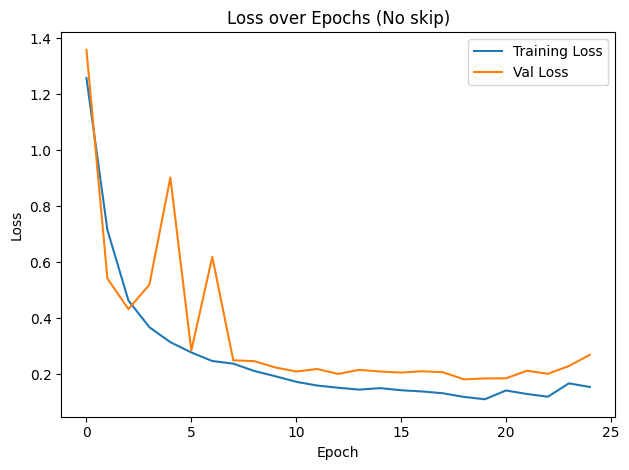

In [20]:
model2 = ResNet18_FCN_NoSkip(num_classes).to(device)
# train_test_model(model2, "No skip")
train_losses, val_losses= train_val(model2)
plot_acc_loss(train_losses, val_losses, "No skip")

In [21]:
test(model2)

Average Pixel-wise Accuracy: 1.0000, Average Mean IoU: 11.1111
